<header style="padding:1px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>5G Quality of Experience using ClearScape Analytics</b>
</header>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Introduction</b></p>
    
<p style = 'font-size:16px;font-family:Arial'>Due to the exponential increase in 5G cellular network users, providing extensive coverage and ensuring maximum Quality of Experience (QoE) has become a significant challenge for global telecommunications. The demand for high-speed connectivity, low latency, and massive data transfer poses obstacles in delivering seamless 5G coverage across diverse geographical areas. Furthermore, transitioning from 4G/LTE to 5G technology introduces complexities in terms of compatibility and network integration. Addressing these challenges is essential to meet the evolving expectations of end-users and ensure optimal QoE.<br>
To tackle these challenges, an analysis of Key Performance Indicators (KPIs) and channel level metrics is conducted to understand their impact on user's perceived QoE. Moreover, we gain valuable insights by investigating YouTube streaming QoE, KPIs, using commercial 4G and 5G cellular networks under different mobility and static scenarios. The demo shows the power of Vantage by utilising its In-DB analytics capabilities to address a critical challenge in telecommunication industry: <br>Predicting quality of experience (QoE) in 5G networks.

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Connect to Vantage and explore the dataset</b></h1>

<p style = 'font-size:16px;font-family:Arial'>You will be prompted to provide the password. Enter your password, press the Enter key, then <b>use down arrow</b> to go to next cell.</p>

In [ ]:
%connect local, hidewarnings=true

In [ ]:
Set query_band='DEMO=Telco_5G_QOE_Analysis_SQL.ipynb;' update for session;

<h2 style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Getting Data for This Demo</b></h2>
<p style = 'font-size:16px;font-family:Arial'>    
We have provided data for this demo on cloud storage. You have the option of either running the demo using foreign tables to access the data without using any storage on your environment or downloading the data to local storage which may yield somewhat faster execution, but there could be considerations of available storage. There are two statements in the following cell, and one is commented out. You may switch which mode you choose by changing the comment string.

In [ ]:
call get_data('DEMO_5G_cloud');    -- takes about 20 seconds, estimated space: 0 MB
--call get_data('DEMO_5G_local');     -- takes about 40 seconds, estimated space: 1MB

<p style = 'font-size:16px;font-family:Arial'>Next is an optional step – if you want to see status of databases/tables created and space used.</p>

In [ ]:
call space_report();  -- optional, takes about 10 seconds

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Exploring source data</b></h1>

<p style = 'font-size:16px;font-family:Arial'> <b>5G Quality of Experience Data <br><br>CLM</b>: Refers to measurements and indicators that provide information about the quality and characteristics of the wireless communication channel between a base station (eNodeB/gNB) and a user equipment (UE) device. These metrics help in assessing the channel conditions and performance of the wireless link. Channel level metrics with 1-second granularity collected using Gnetrack Pro under different scenarios includes CQI, SNR, RSRP, RSRQ, Download & Upload bitrate, Cellid, etc. <br><b>QoE</b>: YouTube Quality of Experience information collected after every 1-second, i.e., Current quality, Video bytes downloaded, Loaded percentage. <br><b>Events</b>: YouTube player events, i.e., Stall, Quality Shift, Paused, Played, Ended<br>

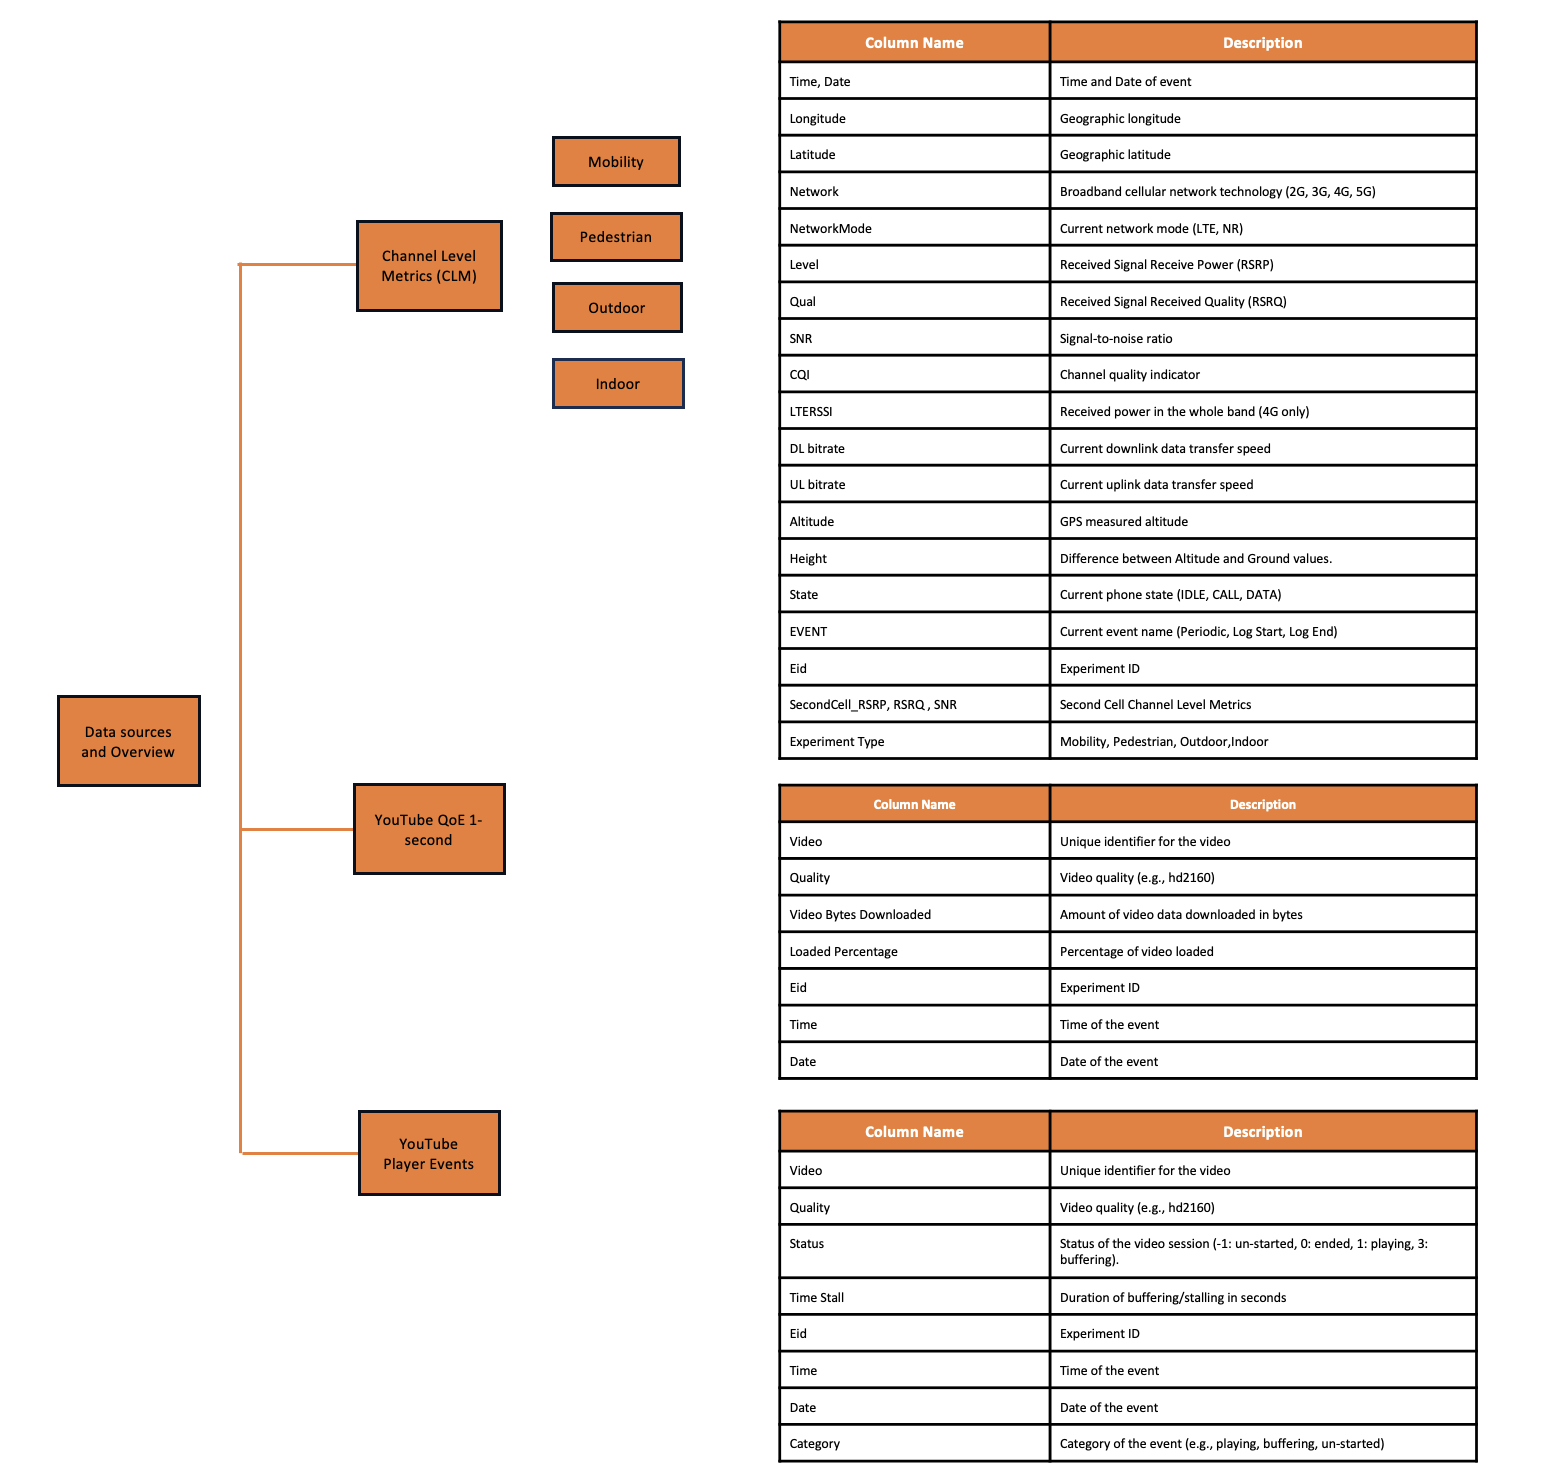

In [ ]:
select top 10 * from Demo_5G.YouTube_QoE;

In [ ]:
select top 10 * from Demo_5G.YouTube_Player_Events;

In [ ]:
select top 10 * from Demo_5G.Channel_Level_Metrics;

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Data Preparation</b></h1>
<p style = 'font-size:16px;font-family:Arial'>Let us first create a combined table of Youtube QoE and Channel level metrics.

In [ ]:
CREATE TABLE CLM_QOE AS (
    SELECT 
        QoE."Times" AS QoE_Time, 
        QoE."Dates" AS QoE_Date, 
        QoE."Eid" AS  Eid, 
        QoE."Video_Bytes_Downloaded",
        QoE."Video",
        QoE."Quality",
        QoE."Loaded_Percentage",
        CLM."Longitude",
        CLM."Latitude",
        CLM."NetworkTech",
        CLM."NetworkMode",
        CLM."Level",
        CLM."Qual",
        CLM."SNR",
        CLM."CQI",
        CLM."LTERSSI",
        CLM."DL_bitrate",
        CLM."UL_bitrate",
        CLM."Altitude",
        CLM."Height",
        CLM."State",
        CLM."Event",
        CLM."SecondCell_RSRP",
        CLM."SecondCell_RSRQ",
        CLM."SecondCell_SNR",
        CLM."Experiment_Type",    
        QoE."Dates" || ' ' ||QoE."Times" AS DateTime
    FROM Demo_5G.YouTube_QoE QoE
    INNER JOIN Demo_5G.Channel_Level_Metrics CLM
        ON QoE."Times" = CLM."Times"
        AND QoE."Dates" = CLM."Dates"
        AND QoE."Eid" = CLM."Eid"
) WITH DATA NO PRIMARY INDEX;

In [ ]:
select top 10 * from CLM_QOE;

In [ ]:
SELECT COUNT(*) AS total_rows FROM CLM_QOE;

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Data Exploration</b></h1> 

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>TD_CategoricalSummary</b></h2>
<p style = 'font-size:16px;font-family:Arial'><b>TD_CATEGORICALSUMMARY </b>function   displays the distinct values and their counts for each specified input table column</p>

In [ ]:
SELECT * FROM TD_CategoricalSummary (
ON CLM_QOE AS InputTable
USING
    TargetColumns ('Experiment_Type','NetworkTech','NetworkMode','Event','State','Eid') 
) AS dt;

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>TD_ColumnSummary</b></h2>
<p style = 'font-size:16px;font-family:Arial'><b>TD_ColumnSummary </b>function  displays Column name, datatype and other demographics like count of NULLs etc for each specified input table column</p>

In [ ]:
SELECT * FROM TD_ColumnSummary (
  ON CLM_QOE AS InputTable
  USING
  TargetColumns ('Longitude','Latitude','LTERSSI','Level')
) AS dt;

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Exploratory Data Analysis using TD_Plot</b></h1> 

<p style = 'font-size:16px;font-family:Arial'><b>TD_Plot</b> provides the ability to generate charts. The generated charts can be in the JPG, PNG, or SVG formats. 

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>
Bar Chart - Video Quality Distribution</h2>

In [ ]:
CREATE MULTISET VOLATILE TABLE BAR_Graph_Videos_4G AS (
    SELECT Video, Quality,Video_Bytes_Downloaded,
        AVG(Loaded_Percentage) OVER (PARTITION BY Quality) AS Average_Loaded_Percentage, 
        Eid, DateTime,
        CASE 
            WHEN Quality = 'hd2160' THEN 1
            WHEN Quality = 'hd1440' THEN 2
            WHEN Quality = 'hd1080' THEN 3
            WHEN Quality = 'hd720' THEN 4
            WHEN Quality IN ('unknown', 'medium', 'large') THEN 5
        END AS Quality_Code,
        1 AS series
    FROM CLM_QOE
    WHERE Eid LIKE '4%'
    GROUP BY Video, Quality, Video_Bytes_Downloaded, Loaded_Percentage, Eid, DateTime
) WITH DATA
On Commit Preserve Rows;

<p style = 'font-size:16px;font-family:Arial'>In table BAR_Graph_Videos_4G we have the metrics for 4G videos

In [ ]:
CREATE MULTISET VOLATILE TABLE BAR_Graph_Videos_5G AS (
    SELECT Video, Quality,Video_Bytes_Downloaded, 
        AVG(Loaded_Percentage) OVER (PARTITION BY Quality) AS Average_Loaded_Percentage, 
        Eid, DateTime,
        CASE 
            WHEN Quality = 'hd2160' THEN 1
            WHEN Quality = 'hd1440' THEN 2
            WHEN Quality = 'hd1080' THEN 3
            WHEN Quality = 'hd720' THEN 4
            WHEN Quality IN ('unknown', 'medium', 'large') THEN 5
        END AS Quality_Code,
        1 AS series
    FROM CLM_QOE
    WHERE Eid LIKE '5%'
    GROUP BY Video, Quality, Video_Bytes_Downloaded,Loaded_Percentage, Eid, DateTime
) WITH DATA
On Commit Preserve Rows;


<p style = 'font-size:16px;font-family:Arial'>In table BAR_Graph_Videos_5G we have the metrics for 5G videos

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(barGraph)
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(BAR_Graph_Videos_4G),
        ROW_AXIS(SEQUENCE(Quality_Code)),
        SERIES_ID(Quality),
        PAYLOAD
        (
           FIELDS("Average_Loaded_Percentage"),
           CONTENT(REAL)
        )
    ) where Quality_Code IN (1,2,3,4),
    
    
    SERIES_SPEC
    (
        TABLE_NAME(BAR_Graph_Videos_5G),
        ROW_AXIS(SEQUENCE(Quality_Code)),
        SERIES_ID(Quality),
        PAYLOAD
        (
           FIELDS("Average_Loaded_Percentage"),
           CONTENT(REAL)
        )
    ) where Quality_Code IN (1,2,3,4),
    
    
    
    FUNC_PARAMS
    (
        LAYOUT(2,1),
        WIDTH(900),
        HEIGHT(600),
        TITLE('Video Quality Distribution'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TITLE ('Video Quality Distribution on 4G Smartphone'),
                TYPE('bar'),
                LEGEND('best'),
                XLABEL('Quality Threshold'),
                YLABEL('Average_Loaded_Percentage')
            ),
            
             (
                ID(2),
                CELL(2,1),
                TITLE ('Video Quality Distribution on 5G Smartphone'),
                TYPE('bar'),
                LEGEND('best'),
                XLABEL('Quality Threshold'),
                YLABEL('Average_Loaded_Percentage')
            )
        ]
    )
);

In [ ]:
Select * from barGraph;

<p style = 'font-size:16px;font-family:Arial'> <b><i>* Right click on the image column and select view image.</b></i> <br>The image should look like below.

<center><img src="images/bargraph.png"/></center>

<p style = 'font-size:16px;font-family:Arial'>From the above Bar Chart we can infer that
<ul style = 'font-size:16px;font-family:Arial'>
<li> hd1440 consistently shows higher average loaded percentages on both 4G and 5G smartphones. </li>
<li> hd1440 provides a better user experience in terms of loading time compared to other quality categories on both networks.</li>
<li> These findings also suggest that network performance can vary for different video quality categories on different networks.</li> 
    <li> Optimal quality choices may depend on the smartphone's network capabilities.</li>

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>Scatter Plot - 5G Vs 4G Mobility and Indoor Stalling Events</h2>

<p style = 'font-size:16px;font-family:Arial'> Let us create subsets of 4G & 5G data for our analysis

In [ ]:
CREATE MULTISET VOLATILE TABLE "5g_time_stall_Mobility" AS (
    SELECT Video, Quality, Status, TimeStall, Eid, Dates,
           CAST(TO_TIMESTAMP(Dates || ' ' || Times, 'DD/MM/YYYY HH24:MI:SS') AS TIMESTAMP(6)) AS Date_Time, Category
    FROM Demo_5G.YouTube_Player_Events
    WHERE SUBSTRING(Eid FROM 1 FOR 1) = '5'
    AND SUBSTRING(Eid FROM 2 FOR 1) = 'M'
    AND Quality IN ('hd2160,', 'hd1080,', 'hd1440,', 'hd720,')
) WITH DATA
On Commit Preserve Rows;

In [ ]:
CREATE MULTISET VOLATILE TABLE "4g_time_stall_Mobility" AS (
    SELECT Video, Quality, Status, TimeStall, Eid, Dates,
           CAST(TO_TIMESTAMP(Dates || ' ' || Times, 'DD/MM/YYYY HH24:MI:SS') AS TIMESTAMP(6)) AS Date_Time, Category
    FROM Demo_5G.YouTube_Player_Events
    WHERE SUBSTRING(Eid FROM 1 FOR 1) = '4'
    AND SUBSTRING(Eid FROM 2 FOR 1) = 'M'
    AND Quality IN ('hd2160,', 'hd1080,', 'hd1440,', 'hd720,')
) WITH DATA               
On Commit Preserve Rows;

In [ ]:
CREATE MULTISET VOLATILE TABLE "4g_time_stall_Indoor" AS (
    SELECT Video, Quality, Status, TimeStall, Eid, Dates,
           CAST(TO_TIMESTAMP(Dates || ' ' || Times, 'DD/MM/YYYY HH24:MI:SS') AS TIMESTAMP(6)) AS Date_Time, Category
    FROM Demo_5G.YouTube_Player_Events
    WHERE SUBSTRING(Eid FROM 1 FOR 1) = '4'
    AND SUBSTRING(Eid FROM 2 FOR 1) = 'I'
    AND Quality IN ('hd2160,', 'hd1080,', 'hd1440,', 'hd720,')
) WITH DATA
On Commit Preserve Rows;

In [ ]:
CREATE MULTISET VOLATILE TABLE "5g_time_stall_Indoor" AS (
    SELECT Video, Quality, Status, TimeStall, Eid, Dates,
           CAST(TO_TIMESTAMP(Dates || ' ' || Times, 'DD/MM/YYYY HH24:MI:SS') AS TIMESTAMP(6)) AS Date_Time, Category
    FROM Demo_5G.YouTube_Player_Events
    WHERE SUBSTRING(Eid FROM 1 FOR 1) = '5'
    AND SUBSTRING(Eid FROM 2 FOR 1) = 'I'
    AND Quality IN ('hd2160,', 'hd1080,', 'hd1440,', 'hd720,')
) WITH DATA
On Commit Preserve Rows;

<p style = 'font-size:16px;font-family:Arial'>Let us check if our timeseries is regular or irregular series.<br>Irregular time series are data sequences where the observations or data points are not uniformly spaced in time. This may happen due to missing data or uneven data collection.

In [ ]:
WITH time_diffs AS (
  SELECT
    Eid,
    MIN(Times) AS Min_Times,
    MAX(Times) AS Max_Times,
    Max_Times - LAG(Max_Times) OVER (ORDER BY Max_Times) AS Time_Diff
  FROM Demo_5G.YouTube_Player_Events
  GROUP BY Eid
)
SELECT
  CASE
    WHEN COUNT(DISTINCT Time_Diff) > 1 THEN 'Irregular'
    ELSE 'Regular' 
  END AS Time_Series_Type
FROM time_diffs;

<p style = 'font-size:16px;font-family:Arial'> Our series is irregular, first let us make the series regular by resampling our data.

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>TD_Resample</b></h2>
<p style = 'font-size:16px;font-family:Arial'>
    <b>TD_Resample</b> function Transforms converts irregular time series into a regular time series and performs linear interpolation.TD_Resample can also be used to alter the sampling interval for a time series.<br>Finding the minimum date, so that we can re-sample the dates from this date onwards which will convert irregular time series into a regular time series.

In [ ]:
SELECT MIN(Date_Time) AS Min_Date,
       MAX(Date_Time) AS Max_Date,
       COUNT(*) AS Total_Count,
       COUNT(DISTINCT Date_Time) AS Unique_Count,
       CASE
           WHEN COUNT(*) <> COUNT(DISTINCT Date_Time) THEN 'Repetitions Detected'
           ELSE 'No Repetitions Found'
       END AS Repetitions_Status
FROM "5g_time_stall_Mobility";


In [ ]:
SELECT MIN(Date_Time) AS Min_Date,
       MAX(Date_Time) AS Max_Date,
       COUNT(*) AS Total_Count,
       COUNT(DISTINCT Date_Time) AS Unique_Count,
       CASE
           WHEN COUNT(*) <> COUNT(DISTINCT Date_Time) THEN 'Repetitions Detected'
           ELSE 'No Repetitions Found'
       END AS Repetitions_Status
FROM "4g_time_stall_Mobility";


In [ ]:
SELECT MIN(Date_Time) AS Min_Date,
       MAX(Date_Time) AS Max_Date,
       COUNT(*) AS Total_Count,
       COUNT(DISTINCT Date_Time) AS Unique_Count,
       CASE
           WHEN COUNT(*) <> COUNT(DISTINCT Date_Time) THEN 'Repetitions Detected'
           ELSE 'No Repetitions Found'
       END AS Repetitions_Status
FROM "5g_time_stall_Indoor";


In [ ]:
SELECT MIN(Date_Time) AS Min_Date,
       MAX(Date_Time) AS Max_Date,
       COUNT(*) AS Total_Count,
       COUNT(DISTINCT Date_Time) AS Unique_Count,
       CASE
           WHEN COUNT(*) <> COUNT(DISTINCT Date_Time) THEN 'Repetitions Detected'
           ELSE 'No Repetitions Found'
       END AS Repetitions_Status
FROM "4g_time_stall_Indoor";


<p style = 'font-size:16px;font-family:Arial'>Using the resample function to convert irregular time series into a regular time series 

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART("4g_resampled_time_stall_Mobility")

TD_RESAMPLE(
    SERIES_SPEC(
        TABLE_NAME("4g_time_stall_Mobility"),
        ROW_AXIS(timecode(date_time)),
        SERIES_ID(Quality),
        PAYLOAD(FIELDS(TimeStall), CONTENT(REAL)
     )
    ),
    FUNC_PARAMS(
        TIMECODE(
            START_VALUE(TIMESTAMP '2022-07-09 04:01:34'), 
            DURATION(minutes(1))
        ),
        INTERPOLATE(LINEAR)
    )
);

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART("5g_resampled_time_stall_Mobility")

TD_RESAMPLE(
    SERIES_SPEC(
        TABLE_NAME("5g_time_stall_Mobility"),
        ROW_AXIS(timecode(date_time)),
        SERIES_ID(Quality),
        PAYLOAD(FIELDS(TimeStall), CONTENT(REAL)
     )
    ),
    FUNC_PARAMS(
        TIMECODE(
            START_VALUE(TIMESTAMP '2022-07-09 03:58:12'), 
            DURATION(minutes(1))
        ),
        INTERPOLATE(LINEAR)
    )
);

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART("5g_resampled_time_stall_Indoor")

TD_RESAMPLE(
    SERIES_SPEC(
        TABLE_NAME("5g_time_stall_Indoor"),
        ROW_AXIS(timecode(date_time)),
        SERIES_ID(Quality),
        PAYLOAD(FIELDS(TimeStall), CONTENT(REAL)
     )
    ),
    FUNC_PARAMS(
        TIMECODE(
            START_VALUE(TIMESTAMP '2022-08-09 15:24:44'), 
            DURATION(minutes(1))
        ),
        INTERPOLATE(LINEAR)
    )
);

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART("4g_resampled_time_stall_Indoor")

TD_RESAMPLE(
    SERIES_SPEC(
        TABLE_NAME("4g_time_stall_Indoor"),
        ROW_AXIS(timecode(date_time)),
        SERIES_ID(Quality),
        PAYLOAD(FIELDS(TimeStall), CONTENT(REAL)
     )
    ),
    FUNC_PARAMS(
        TIMECODE(
            START_VALUE(TIMESTAMP '2022-08-09 15:31:35'), 
            DURATION(minutes(1))
        ),
        INTERPOLATE(LINEAR)
    )
);

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(scatter_graph_timestall)
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME("4g_resampled_time_stall_Mobility"),
        ROW_AXIS(TIMECODE(ROW_I)),
        SERIES_ID(Quality),
        PAYLOAD
        (
           FIELDS(TimeStall),
           CONTENT(REAL)
        )
    ),
    
    SERIES_SPEC
    (
        TABLE_NAME("5g_resampled_time_stall_Mobility"),
        ROW_AXIS(TIMECODE(ROW_I)),
        SERIES_ID(Quality),
        PAYLOAD
        (
           FIELDS(TimeStall),
           CONTENT(REAL)
        )
    ),
    

     SERIES_SPEC
    (
        TABLE_NAME("4g_resampled_time_stall_Indoor"),
        ROW_AXIS(TIMECODE(ROW_I)),
        SERIES_ID(Quality),
        PAYLOAD
        (
           FIELDS(TimeStall),
           CONTENT(REAL)
        )
    ),
    
    SERIES_SPEC
    (
        TABLE_NAME("5g_resampled_time_stall_Indoor"),
        ROW_AXIS(TIMECODE(ROW_I)),
        SERIES_ID(Quality),
        PAYLOAD
        (
           FIELDS(TimeStall),
           CONTENT(REAL)
        )
    ),
    
    FUNC_PARAMS
    (
        LAYOUT(4, 1),
        WIDTH(1500),
        HEIGHT(600),
        TITLE('SCATTER GRAPH'),
        PLOTS[
            (
                ID(1),
                CELL(1, 1),
                TITLE ('4G Stalling on Video Resolutions Mobility'),
                TYPE('scatter'),
                LEGEND('best'),
                XLABEL('TIME SERIES'),
                YLABEL('Stalling Time in minutes')
            ),
            
            (
                ID(2),
                CELL(2, 1),
                TITLE ('5G Stalling on Video Resolutions Mobility'),
                TYPE('scatter'),
                LEGEND('best'),
                XLABEL('TIME SERIES'),
                YLABEL('Stalling Time in minutes')
            ),
            
            (
                ID(3),
                CELL(3, 1),
                TITLE ('4G Stalling on Video Resolutions Indoor'),
                TYPE('scatter'),
                LEGEND('best'),
                XLABEL('TIME SERIES'),
                YLABEL('Stalling Time in minutes')
            ),
            
            (
                ID(4),
                CELL(4, 1),
                TITLE ('5G Stalling on Video Resolutions Indoor'),
                TYPE('scatter'),
                LEGEND('best'),
                XLABEL('TIME SERIES'),
                YLABEL('Stalling Time in minutes')
            )
        ]
    )
);


In [ ]:
select * from scatter_graph_timestall;

<p style = 'font-size:16px;font-family:Arial'> <b><i>* Right click on the image column and select view image.</b></i> <br>The image should look like below.

<center><img src="images/scatter.png"/></center>

<p style = 'font-size:16px;font-family:Arial'>From the above Scatter Plot we can infer that
<ul style = 'font-size:16px;font-family:Arial'>
<li> 4G on mobility, hd1440 exhibited the highest stalling duration over time, while hd720 experienced the least stalling. On 5G in mobility, hd2160 had brief but high stalling, while hd1440 showed less stalling but played for longer durations. </li>
<li>Shifting to indoor settings on 4G, hd2160 initially had the highest stalling and hd1440 had minimal stalling.</li>
<li>Indoor scenario on 5G, hd2160 had persistent stalling, hd1440 had the least stalling, and both hd1080 and hd720 showed minimal interruptions.</li>
 <li> This indicates that higher video qualities tend to experience more stalling, especially in challenging network conditions, while lower qualities offer smoother playback</li>

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>Line Graph - 5G vs 4G ( CQI, RSRP, RSRQ, SNR)</h2>


In [ ]:
CREATE MULTISET VOLATILE TABLE CLM_5G_CQI AS (
  SELECT
    CQI,
    Experiment_Type,
    Experiment_Count,
    CASE
      WHEN MAX(Experiment_Count_Standardized) OVER (PARTITION BY CQI) = MIN(Experiment_Count_Standardized) OVER (PARTITION BY CQI) THEN 0 -- Handle division by zero
      ELSE (Experiment_Count_Standardized - MIN(Experiment_Count_Standardized) OVER (PARTITION BY CQI)) / NULLIF(MAX(Experiment_Count_Standardized) OVER (PARTITION BY CQI) - MIN(Experiment_Count_Standardized) OVER (PARTITION BY CQI), 0)
    END AS Experiment_Count_Standardized_Range
  FROM (
    SELECT
      CQI,
      Experiment_Type,
      Experiment_Count,
      COALESCE((Experiment_Count - AVG(Experiment_Count) OVER (PARTITION BY CQI)) / NULLIF(STDDEV_POP(Experiment_Count) OVER (PARTITION BY CQI), 0), 0) AS Experiment_Count_Standardized
    FROM (
      SELECT
        CQI,
        Experiment_Type,
        COUNT(*) AS Experiment_Count
      FROM CLM_QOE
      WHERE NetworkTech = '5G'
      GROUP BY CQI, Experiment_Type
    ) t
  ) t2
) WITH DATA
on commit preserve rows;

In [ ]:
CREATE  MULTISET VOLATILE TABLE CLM_4G_CQI AS (
  SELECT
    CQI,
    Experiment_Type,
    Experiment_Count,
    CASE
      WHEN MAX(Experiment_Count_Standardized) OVER (PARTITION BY CQI) = MIN(Experiment_Count_Standardized) OVER (PARTITION BY CQI) THEN 0 -- Handle division by zero
      ELSE (Experiment_Count_Standardized - MIN(Experiment_Count_Standardized) OVER (PARTITION BY CQI)) / NULLIF(MAX(Experiment_Count_Standardized) OVER (PARTITION BY CQI) - MIN(Experiment_Count_Standardized) OVER (PARTITION BY CQI), 0)
    END AS Experiment_Count_Standardized_Range
  FROM (
    SELECT
      CQI,
      Experiment_Type,
      Experiment_Count,
      COALESCE((Experiment_Count - AVG(Experiment_Count) OVER (PARTITION BY CQI)) / NULLIF(STDDEV_POP(Experiment_Count) OVER (PARTITION BY CQI), 0), 0) AS Experiment_Count_Standardized
    FROM (
      SELECT
        CQI,
        Experiment_Type,
        COUNT(*) AS Experiment_Count
      FROM CLM_QOE
      WHERE NetworkTech = '4G'
      GROUP BY CQI, Experiment_Type
    ) t
  ) t2
) WITH DATA
on commit preserve rows;

In [ ]:
CREATE MULTISET VOLATILE TABLE CLM_5G_Level AS (
  SELECT
    Level,
    Experiment_Type,
    Experiment_Count,
    CASE
      WHEN MAX(Experiment_Count_Standardized) OVER (PARTITION BY Level) = MIN(Experiment_Count_Standardized) OVER (PARTITION BY Level) THEN 0 -- Handle division by zero
      ELSE (Experiment_Count_Standardized - MIN(Experiment_Count_Standardized) OVER (PARTITION BY Level)) / NULLIF(MAX(Experiment_Count_Standardized) OVER (PARTITION BY Level) - MIN(Experiment_Count_Standardized) OVER (PARTITION BY Level), 0)
    END AS Experiment_Count_Standardized_Range
  FROM (
    SELECT
      Level,
      Experiment_Type,
      Experiment_Count,
      COALESCE((Experiment_Count - AVG(Experiment_Count) OVER (PARTITION BY Level)) / NULLIF(STDDEV_POP(Experiment_Count) OVER (PARTITION BY Level), 0), 0) AS Experiment_Count_Standardized
    FROM (
      SELECT
        Level,
        Experiment_Type,
        COUNT(*) AS Experiment_Count
      FROM CLM_QOE
      WHERE NetworkTech = '5G'
      GROUP BY Level, Experiment_Type
    ) t
  ) t2
) WITH DATA
on commit preserve rows;


In [ ]:
CREATE MULTISET VOLATILE TABLE CLM_4G_Level AS (
  SELECT
    Level,
    Experiment_Type,
    Experiment_Count,
    CASE
      WHEN MAX(Experiment_Count_Standardized) OVER (PARTITION BY Level) = MIN(Experiment_Count_Standardized) OVER (PARTITION BY Level) THEN 0 -- Handle division by zero
      ELSE (Experiment_Count_Standardized - MIN(Experiment_Count_Standardized) OVER (PARTITION BY Level)) / NULLIF(MAX(Experiment_Count_Standardized) OVER (PARTITION BY Level) - MIN(Experiment_Count_Standardized) OVER (PARTITION BY Level), 0)
    END AS Experiment_Count_Standardized_Range
  FROM (
    SELECT
      Level,
      Experiment_Type,
      Experiment_Count,
      COALESCE((Experiment_Count - AVG(Experiment_Count) OVER (PARTITION BY Level)) / NULLIF(STDDEV_POP(Experiment_Count) OVER (PARTITION BY Level), 0), 0) AS Experiment_Count_Standardized
    FROM (
      SELECT
        Level,
        Experiment_Type,
        COUNT(*) AS Experiment_Count
      FROM CLM_QOE
      WHERE NetworkTech = '4G'
      GROUP BY Level, Experiment_Type
    ) t
  ) t2
) WITH DATA
on commit preserve rows;


In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(Benchamrking_CLM)
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(CLM_5G_CQI),
        ROW_AXIS(SEQUENCE(CQI)),
        SERIES_ID(Experiment_Type),
        PAYLOAD
        (
           FIELDS(Experiment_Count_Standardized_Range),
           CONTENT(REAL)
        )
    ),
    
    SERIES_SPEC
    (
        TABLE_NAME(CLM_4G_CQI ),
        ROW_AXIS(SEQUENCE(CQI)),
        SERIES_ID(Experiment_Type),
        PAYLOAD
        (
           FIELDS(Experiment_Count_Standardized_Range),
           CONTENT(REAL))
    
    ),
    
    SERIES_SPEC
    (
        TABLE_NAME(CLM_5G_Level ),
        ROW_AXIS(SEQUENCE(Level)),
        SERIES_ID(Experiment_Type),
        PAYLOAD
        (
           FIELDS(Experiment_Count_Standardized_Range),
           CONTENT(REAL))
    
    ),
    SERIES_SPEC
    (
        TABLE_NAME(CLM_4G_Level ),
        ROW_AXIS(SEQUENCE(Level)),
        SERIES_ID(Experiment_Type),
        PAYLOAD
        (
           FIELDS(Experiment_Count_Standardized_Range),
           CONTENT(REAL))
    
    ),
    
    
    FUNC_PARAMS
    (
        LAYOUT(2,2),
        WIDTH(1000),
        HEIGHT(800),
        TITLE('4G Vs 5G Channel Level Metric Performance '),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TYPE('line'),
                Title('5G CQI'),
                MARKER('o'),
                LEGEND('best'),
                XLABEL('CQI'),
                YLABEL('Frequecny')
            ),(
                ID(2),
                CELL(1,2),
                TYPE('line'),
                Title('4G CQI'),
                MARKER('o'),
                LEGEND('best'),
                XLABEL('CQI'),
                YLABEL('Frequecny')
            ),
            
            (
                ID(3),
                CELL(2,1),
                TYPE('line'),
                Title('5G RSRP'),
                MARKER('o'),
                LEGEND('best'),
                XLABEL('RSRP'),
                YLABEL('Frequecny')
            ),
            (
                ID(4),
                CELL(2,2),
                TYPE('line'),
                Title('4G RSRP'),
                MARKER('o'),
                LEGEND('best'),
                XLABEL('RSRP'),
                YLABEL('Frequecny')
            )

        ]
    )
);

In [ ]:
select * from Benchamrking_CLM;

<p style = 'font-size:16px;font-family:Arial'> <b><i>* Right click on the image column and select view image.</b></i> <br>The image should look like below.

<center><img src="images/line.png"/></center>

<p style = 'font-size:16px;font-family:Arial'>From the above line chart we can infer that
<ul style = 'font-size:16px;font-family:Arial'>
<li> The spread-out distribution in the 5G and 4G CQI graphs indicates that the CQI values vary across different experiments, higher values indicating better signal quality.</li>
<li>In the case of RSRP, the presence of frequent spikes in both the 5G and 4G RSRP graphs suggests significant fluctuations in signal strength. The spikes indicate instances where the RSRP values deviate from the average or expected levels. Negative values of RSRP indicating relatively weaker signal power.</li>
<li>Overall, these observations provide insights into the performance of CQI and RSRP metrics across different experiments and network technologies. The variations and patterns in CQI and RSRP values reflect the changing channel conditions, signal quality, and signal power, which can impact the overall network performance and user experience.</li>

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Feature Engineering and Selection</b></h1> 


<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>
Target Variable</h2>

<ul style = 'font-size:16px;font-family:Arial'>
<li>To identify a user's quality of experience using youtube video statistics we derive "load rate", a metric can be used to represent how smooth the video is playing. </li>
    <li>If the load rate will is low there will be more buffering time and in turn will impact user's overall viewing  experience and vice versa</li>
    </ul>
 <ul style = 'font-size:16px;font-family:Arial'> Derive Features Include  
    <li><b>Load_rate</b>  = loaded percentage/ (current time)-(start time of the experiment) i.e Duration of Experiment</li>
    <li><b>Rate_category</b> = (Less Then 0.3 = Low),  (Between  0.3 and 0.5 = Medium), (Above 0.5 - High)</li>
    <li><b>Distance</b> = Total Haversine Distance for EIDs </li>

In [ ]:
CREATE MULTISET VOLATILE TABLE CLM_ADS AS (
  SELECT dt.*,  
    CASE
      WHEN dt.load_rate >= 0 AND dt.load_rate <= 0.30 THEN 'low'
      WHEN dt.load_rate >= 0.30 AND dt.load_rate < 0.50 THEN 'med'
      ELSE 'high'
    END AS rate_category
    
  FROM (
    select CLM_QOE.*,  
     TO_TIMESTAMP(CLM_QOE."DateTime",'DD/MM/YYYY HH24:MI:SS') AS OTHER_TIME,
     MIN(TO_TIMESTAMP(CLM_QOE."DateTime",'DD/MM/YYYY HH24:MI:SS')) 
     OVER (PARTITION BY CLM_QOE."Eid") AS MIN_TIME,
     (OTHER_TIME - MIN_TIME) HOUR(2) TO SECOND AS TIME_DIFF,
     CAST(EXTRACT(HOUR  FROM TIME_DIFF) * 3600
     + EXTRACT(MINUTE FROM TIME_DIFF) * 60
      + EXTRACT(SECOND FROM TIME_DIFF) AS INT) AS TIME_DIFF_SECS,
      CLM_QOE.Loaded_Percentage / NULLIFZERO (TIME_DIFF_SECS) AS LOAD_RATE
      FROM CLM_QOE
  ) AS dt
) WITH DATA
On commit preserve rows;

In [ ]:
select top 10 * from CLM_ADS;

In [ ]:
SELECT * FROM TD_CategoricalSummary (
ON CLM_ADS AS InputTable
USING
    TargetColumns ('rate_category') 
) AS dt;

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>
Data Preparation</h2>

<p style = 'font-size:16px;font-family:Arial'><b>Label Encoding </b>
<p style = 'font-size:16px;font-family:Arial'><b>TD_OrdinalEncodingFit </b>function identifies distinct categorical values from an input table or a user-defined list and returns the distinct categorical values along with the ordinal value for each category.The <b>TD_OrdinalEncodingTransform</b> function maps the categorical value to a specified ordinal value using the TD_OrdinalEncodingFit output.</p>

In [ ]:
CREATE MULTISET VOLATILE TABLE CLM_ADS_ENCODED AS (
SELECT * FROM TD_OrdinalEncodingFit (
ON CLM_ADS AS InputTable
USING
TargetColumn('Quality','NetworkTech','NetworkMode','Experiment_Type','rate_category')
Approach ('AUTO')
StartValue (0,0,0,0,0)
DefaultValue (-1,-1,-1,-1,-1)
) AS dt
) WITH DATA
On commit preserve rows;

In [ ]:
select top 10 * from CLM_ADS_ENCODED;

In [ ]:
CREATE MULTISET VOLATILE TABLE CLM_ADS_TRANSFORMED AS (
SELECT * FROM TD_OrdinalEncodingTransform (
ON CLM_ADS as InputTable
ON CLM_ADS_ENCODED as FitTable Dimension
USING
ACCUMULATE('QoE_Time','QoE_Date','Eid','Video_Bytes_Downloaded','Video','Loaded_Percentage', 'Longitude','Latitude','Level','Qual','SNR','CQI', 'LTERSSI', 'DL_bitrate','UL_bitrate','Altitude','Height','State','EVENT','SecondCell_RSRP','SecondCell_RSRQ','SecondCell_SNR', 'DateTime','OTHER_TIME', 'MIN_TIME', 'TIME_DIFF','TIME_DIFF_SECS','Load_Rate')
) AS dt
) WITH DATA
On commit preserve rows;
    

In [ ]:
select top 10 * from CLM_ADS_TRANSFORMED;

<p style = 'font-size:16px;font-family:Arial'><b>TD_TrainTestSplit </b>The function randomly divides the data sets into train and test subsets to evaluate machine learning algorithms and validation processes. The first subset is used to train the model. The second subset is used to make predictions and compare the predictions to actual values. </p>

In [ ]:
CREATE MULTISET TABLE CLM_ADS_TEST AS (
select * from TD_TrainTestSplit (
ON CLM_ADS_TRANSFORMED AS InputTable
USING
TrainSize(0.7)
TestSize(0.3)
)as dt WHERE TD_isTrainRow = 0
) WITH DATA;

In [ ]:
CREATE MULTISET TABLE CLM_ADS_TRAIN AS (
select * from TD_TrainTestSplit (
ON CLM_ADS_TRANSFORMED AS InputTable
USING
TrainSize(0.7)
TestSize(0.3)
)as dt WHERE TD_isTrainRow = 1
) WITH DATA;

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Model Training and Evaluation </b> </h1>

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>
Decision Forest</h2>
<p style = 'font-size:16px;font-family:Arial'><b>TD_DecisionForest</b> function is an ensemble algorithm used for classification and regression predictive modeling problems. It is an extension of bootstrap aggregation (bagging) of decision trees. 
<p style = 'font-size:16px;font-family:Arial'>This function takes the training data as input, as well as the following function parameters</p>
    <ul style = 'font-size:16px;font-family:Arial'>
        <li>InputColumns; list or range of columns used as features (we used an ordinal reference of columns 2:217)</li>
        <li>ResponseColumn; the dependent or target value (we used “class”, the first column)</li>
        <li>TreeType; either CLASSIFICATION or REGRESSION</li>
    <li>Other hyperparameter values detailed in the documentation</li>
        </ul>

<p style = 'font-size:16px;font-family:Arial'> <b><i>* Below step creates model, due to limited resources of VM may take 2-3 minutes to run.</b></i>

In [ ]:
CREATE MULTISET TABLE CLM_ADS_MDL_DF AS (
select * from TD_DecisionForest (
ON CLM_ADS_TRAIN AS InputTable PARTITION BY ANY
USING
   InputColumns ('Level','Qual','SNR','CQI','LTERSSI','DL_bitrate','UL_bitrate','Altitude','Height','Quality','NetworkTech','NetworkMode','Experiment_Type')
   ResponseColumn('rate_category')
   MaxDepth (50)
   MinNodeSize (20)
   NumTrees (100)
   ModelType('classification')
) as dt
) WITH DATA
;

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>
XGboost</h2>
<p style = 'font-size:16px;font-family:Arial'>
 The <b>TD_XGBoost </b>is an implementation of the gradient boosted decision tree designed for speed and performance. In gradient boosting, each iteration fits a model to the residuals (errors) of the previous iteration to correct the errors made by existing models. The predicted residual is multiplied by this learning rate and then added to the previous prediction. Models are added sequentially until no further improvements can be made. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

<p style = 'font-size:16px;font-family:Arial'> <b><i>* Below step creates model, due to limited resources of VM may take 2-3minutes to run.</b></i>

In [ ]:
CREATE MULTISET TABLE CLM_ADS_MDL_XGB AS (
select * from TD_XGBoost (
ON CLM_ADS_TRAIN AS InputTable PARTITION BY ANY
USING
   InputColumns ('Level','Qual','SNR','CQI','LTERSSI','DL_bitrate','UL_bitrate','Altitude','Height','Quality','NetworkTech','NetworkMode','Experiment_Type')
   ResponseColumn('rate_category')
   MaxDepth (50)
   MinNodeSize (20)    
   ModelType('classification')
) as dt
) WITH DATA;

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>
Macro Model - Combined</h2>

<p style = 'font-size:16px;font-family:Arial'> Let us do predictions based on the models created above.

<h3 style = 'font-size:16px;font-family:Arial'>Decision Forest</h3>

In [ ]:
CREATE MULTISET VOLATILE TABLE CLM_ADS_PRED_DF AS (
SELECT * FROM TD_DecisionForestPredict (
ON CLM_ADS_TEST AS InputTable PARTITION BY ANY
ON CLM_ADS_MDL_DF AS ModelTable DIMENSION
USING
  IdColumn ('DateTime')
  Accumulate('rate_category')
) AS dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

In [ ]:
select top 10* from CLM_ADS_PRED_DF;

<h3 style = 'font-size:16px;font-family:Arial'>XG-boost</h3>

In [ ]:
CREATE MULTISET VOLATILE TABLE CLM_ADS_PRED_XGB AS (
SELECT * FROM TD_XGBoostPredict (
ON CLM_ADS_TEST AS InputTable PARTITION BY ANY
ON CLM_ADS_MDL_XGB AS ModelTable DIMENSION ORDER BY task_index, tree_num, iter, class_num, 
tree_order
USING
  IdColumn ('DateTime')
  Accumulate('rate_category')
    ModelType('Classification')
) AS dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

In [ ]:
select top 10* from CLM_ADS_PRED_XGB;

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>
Model Evaluation</h2>


<p style = 'font-size:16px;font-family:Arial'><b>TD_ClassificationEvaluator</b>In classification problems, a confusion matrix is used to visualize the performance of a classifier. The confusion matrix contains predicted labels represented across the row-axis and actual labels represented across the column-axis. Each cell in the confusion matrix corresponds to the count of occurrences of labels in the test data. TD_ClassificationEvaluator functions creates the confusion matrix. 

In [ ]:
SELECT * from TD_CLASSIFICATIONEVALUATOR(
ON  CLM_ADS_PRED_DF AS InputTable
USING
Labels(0,1,2)
ObservationColumn('rate_category')
PredictionColumn ('prediction')
) as dt;

In [ ]:
SELECT * from TD_CLASSIFICATIONEVALUATOR(
ON  CLM_ADS_PRED_XGB AS InputTable
USING
Labels(0,1,2)
ObservationColumn('rate_category')
PredictionColumn ('prediction')
) as dt;

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>
Feature selection using GLM</h2>

<p style = 'font-size:16px;font-family:Arial'>We can use GLM for chosing the significant features 

In [ ]:
CREATE VOLATILE TABLE TD_Glm_FeatureSelection AS(
SELECT * FROM TD_GLM (
ON CLM_ADS_TRANSFORMED
USING
InputColumns('Level','Qual','SNR','CQI','LTERSSI','DL_bitrate','UL_bitrate','Altitude','Height','Quality','NetworkTech','NetworkMode','Experiment_Type')
ResponseColumn('rate_category')
MaxIterNum(100)
RegularizationLambda(0.027)
Alpha(0)
IterNumNoChange(50)
Intercept('true')
) AS dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

In [ ]:
select * from TD_Glm_FeatureSelection order by attribute;

<p style = 'font-size:16px;font-family:Arial'>We can see the estimates column to see its significance of the attribute on the model.  

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>
Micro-models (dividing the dataset on experiment types)</h2>

<p style = 'font-size:16px;font-family:Arial'>Let us divide our dataset based on experiment types.

In [ ]:
CREATE MULTISET VOLATILE TABLE CLM_ADS_INDOOR AS (
select * from CLM_ADS_TRANSFORMED where Experiment_Type = 0
) WITH DATA
ON COMMIT PRESERVE ROWS;

In [ ]:
CREATE MULTISET VOLATILE TABLE CLM_ADS_MOBILITY AS (
select * from CLM_ADS_TRANSFORMED where Experiment_Type = 1
) WITH DATA
ON COMMIT PRESERVE ROWS;

In [ ]:
CREATE MULTISET VOLATILE TABLE CLM_ADS_OUTDOOR AS (
select * from CLM_ADS_TRANSFORMED where Experiment_Type = 2
) WITH DATA
ON COMMIT PRESERVE ROWS;

In [ ]:
CREATE MULTISET VOLATILE TABLE CLM_ADS_PEDESTRIAN AS (
select * from CLM_ADS_TRANSFORMED where Experiment_Type = 3
) WITH DATA
ON COMMIT PRESERVE ROWS;

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>Indoor</h2>

<p style = 'font-size:16px;font-family:Arial'>Now let's create train and test dataset for experiment type =0 i.e Indoor

In [ ]:
CREATE MULTISET VOLATILE TABLE INDOOR_TRAIN AS (
select * from TD_TrainTestSplit (
ON CLM_ADS_INDOOR AS InputTable
USING
TrainSize(0.7)
TestSize(0.3)
)as dt WHERE TD_isTrainRow = 1
) WITH DATA
ON COMMIT PRESERVE ROWS;

In [ ]:
CREATE MULTISET VOLATILE TABLE INDOOR_TEST AS (
select * from TD_TrainTestSplit (
ON CLM_ADS_INDOOR AS InputTable
USING
TrainSize(0.7)
TestSize(0.3)
)as dt WHERE TD_isTrainRow = 0
) WITH DATA
ON COMMIT PRESERVE ROWS;

<h3 style = 'font-size:16px;font-family:Arial'>Model Creation for Indoor</h3>

<p style = 'font-size:16px;font-family:Arial'>As we have seen earlier in macro models that Decision Forest model gave better results, hence we will use Decision forest for micro models.

<p style = 'font-size:16px;font-family:Arial'> <b><i>* Below steps creates model, due to limited resources of VM may take 2-3 minutes to run.</b></i>

In [ ]:
CREATE MULTISET VOLATILE TABLE INDOOR_MDL AS (
select * from TD_DecisionForest (
ON INDOOR_TRAIN AS InputTable PARTITION BY ANY
USING
   InputColumns ('Level','Qual','SNR','CQI','LTERSSI','DL_bitrate','UL_bitrate','Altitude','Height','Quality','NetworkTech','NetworkMode')
   ResponseColumn('rate_category')
   MaxDepth (50)
   MinNodeSize (20)
   NumTrees (100)
   ModelType ('classification')
) as dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

<h3 style = 'font-size:16px;font-family:Arial'>Predicition for Indoor</h3>

In [ ]:
CREATE MULTISET VOLATILE TABLE INDOOR_PRED AS (
SELECT * FROM TD_DecisionForestPredict (
ON INDOOR_TEST AS InputTable PARTITION BY ANY
ON INDOOR_MDL AS ModelTable DIMENSION
USING
  IdColumn ('DateTime')
  Accumulate('rate_category')
) AS dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

In [ ]:
select top 10* from INDOOR_PRED;

<h3 style = 'font-size:16px;font-family:Arial'>Model Evaluation for Indoor</h3>

In [ ]:
SELECT * from TD_CLASSIFICATIONEVALUATOR(
ON  INDOOR_PRED AS InputTable
USING
Labels(0,1,2)
ObservationColumn('rate_category')
PredictionColumn ('prediction')
) as dt;

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>Outdoor</h2>
<p style = 'font-size:16px;font-family:Arial'>Now let's create train and test dataset for experiment type =1 i.e Outdoor

In [ ]:
CREATE MULTISET VOLATILE TABLE OUTDOOR_TRAIN AS (
select * from TD_TrainTestSplit (
ON CLM_ADS_OUTDOOR AS InputTable
USING
TrainSize(0.7)
TestSize(0.3)
)as dt WHERE TD_isTrainRow = 1
) WITH DATA
ON COMMIT PRESERVE ROWS;

In [ ]:
CREATE MULTISET VOLATILE TABLE OUTDOOR_TEST AS (
select * from TD_TrainTestSplit (
ON CLM_ADS_OUTDOOR AS InputTable
USING
TrainSize(0.7)
TestSize(0.3)
)as dt WHERE TD_isTrainRow = 0
) WITH DATA
ON COMMIT PRESERVE ROWS;

<h3 style = 'font-size:16px;font-family:Arial'>Model Creation for Outdoor</h3>

<p style = 'font-size:16px;font-family:Arial'> <b><i>* Below steps creates model, due to limited resources of VM may take 2-3 minutes to run.</b></i>

In [ ]:
CREATE MULTISET VOLATILE TABLE OUTDOOR_MDL AS (
select * from TD_DecisionForest (
ON OUTDOOR_TRAIN AS InputTable PARTITION BY ANY
USING
   InputColumns ('Level','Qual','SNR','CQI','LTERSSI','DL_bitrate','UL_bitrate','Altitude','Height','Quality','NetworkTech','NetworkMode')
   ResponseColumn('rate_category')
   MaxDepth (50)
   MinNodeSize (20)
   NumTrees (100)
   ModelType ('classification')
) as dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

<h3 style = 'font-size:16px;font-family:Arial'>Predicition for Outdoor</h3>

In [ ]:
CREATE MULTISET VOLATILE TABLE OUTDOOR_PRED AS (
SELECT * FROM TD_DecisionForestPredict (
ON OUTDOOR_TEST AS InputTable PARTITION BY ANY
ON OUTDOOR_MDL AS ModelTable DIMENSION
USING
  IdColumn ('DateTime')
  Accumulate('rate_category')
) AS dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

In [ ]:
select top 10* from OUTDOOR_PRED;

<h3 style = 'font-size:16px;font-family:Arial'>Model Evaluation for Outdoor</h3>

In [ ]:
SELECT * from TD_CLASSIFICATIONEVALUATOR(
ON  OUTDOOR_PRED AS InputTable
USING
Labels(0,1,2)
ObservationColumn('rate_category')
PredictionColumn ('prediction')
) as dt;


<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>Mobility</h2>
<p style = 'font-size:16px;font-family:Arial'>Now let's create train and test dataset for experiment type =2 i.e Mobility

In [ ]:
CREATE MULTISET VOLATILE TABLE MOBILITY_TRAIN AS (
select * from TD_TrainTestSplit (
ON CLM_ADS_MOBILITY AS InputTable
USING
TrainSize(0.7)
TestSize(0.3)
)as dt WHERE TD_isTrainRow = 1
) WITH DATA
ON COMMIT PRESERVE ROWS;

In [ ]:
CREATE VOLATILE TABLE MOBILITY_TEST AS (
select * from TD_TrainTestSplit (
ON CLM_ADS_MOBILITY AS InputTable
USING
TrainSize(0.7)
TestSize(0.3)
)as dt WHERE TD_isTrainRow = 0
) WITH DATA
ON COMMIT PRESERVE ROWS;

<h3 style = 'font-size:16px;font-family:Arial'>Model Creation for Mobility</h3>

<p style = 'font-size:16px;font-family:Arial'> <b><i>* Below steps creates model, due to limited resources of VM may take 2-3 minutes to run.</b></i>

In [ ]:
CREATE MULTISET VOLATILE TABLE MOBILITY_MDL AS (
select * from TD_DecisionForest (
ON MOBILITY_TRAIN AS InputTable PARTITION BY ANY
USING
   InputColumns ('Level','Qual','SNR','CQI','LTERSSI','DL_bitrate','UL_bitrate','Altitude','Height','Quality','NetworkTech','NetworkMode')
   ResponseColumn('rate_category')
   MaxDepth (50)
   MinNodeSize (20)
   NumTrees (100)
   ModelType ('classification')
) as dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

<h3 style = 'font-size:16px;font-family:Arial'>Predicition for Mobility</h3>

In [ ]:
CREATE MULTISET VOLATILE TABLE MOBILITY_PRED AS (
SELECT * FROM TD_DecisionForestPredict (
ON MOBILITY_TEST AS InputTable PARTITION BY ANY
ON MOBILITY_MDL AS ModelTable DIMENSION
USING
  IdColumn ('DateTime')
  Accumulate('rate_category')
) AS dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

In [ ]:
select top 10* from MOBILITY_PRED;

<h3 style = 'font-size:16px;font-family:Arial'>Model Evaluation for Mobility</h3>

In [ ]:
SELECT * from TD_CLASSIFICATIONEVALUATOR(
ON  MOBILITY_PRED AS InputTable
USING
Labels(0,1,2)
ObservationColumn('rate_category')
PredictionColumn ('prediction')
) as dt;

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>Pedestrian</h2>
<p style = 'font-size:16px;font-family:Arial'>Now let's create train and test dataset for experiment type =3 i.e Pedestrian

In [ ]:
CREATE MULTISET VOLATILE TABLE PEDESTRIAN_TRAIN AS (
select * from TD_TrainTestSplit (
ON CLM_ADS_PEDESTRIAN AS InputTable
USING
TrainSize(0.7)
TestSize(0.3)
)as dt WHERE TD_isTrainRow = 1
) WITH DATA
ON COMMIT PRESERVE ROWS;

In [ ]:
CREATE MULTISET VOLATILE TABLE PEDESTRIAN_TEST AS (
select * from TD_TrainTestSplit (
ON CLM_ADS_PEDESTRIAN AS InputTable
USING
TrainSize(0.7)
TestSize(0.3)
)as dt WHERE TD_isTrainRow = 0
) WITH DATA
ON COMMIT PRESERVE ROWS;

<h3 style = 'font-size:16px;font-family:Arial'>Model Creation for Pedestrian</h3>

<p style = 'font-size:16px;font-family:Arial'> <b><i>* Below steps creates model, due to limited resources of VM may take 2-3 minutes to run.</b></i>

In [ ]:
CREATE VOLATILE TABLE PEDESTRIAN_MDL AS (
select * from TD_DecisionForest (
ON PEDESTRIAN_TRAIN AS InputTable PARTITION BY ANY
USING
   InputColumns ('Level','Qual','SNR','CQI','LTERSSI','DL_bitrate','UL_bitrate','Altitude','Height','Quality','NetworkTech','NetworkMode')
   ResponseColumn('rate_category')
   MaxDepth (50)
   MinNodeSize (20)
   NumTrees (100)
   ModelType ('classification')
) as dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

<h3 style = 'font-size:16px;font-family:Arial'>Predicition for Pedestrian</h3>

In [ ]:
CREATE MULTISET VOLATILE TABLE PEDESTRIAN_PRED AS (
SELECT * FROM TD_DecisionForestPredict (
ON PEDESTRIAN_TEST AS InputTable PARTITION BY ANY
ON PEDESTRIAN_MDL AS ModelTable DIMENSION
USING
  IdColumn ('DateTime')
  Accumulate('rate_category')
) AS dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

In [ ]:
select top 10* from PEDESTRIAN_PRED;

<h3 style = 'font-size:16px;font-family:Arial'>Model Evaluation for Pedestrian</h3>

In [ ]:
SELECT * from TD_CLASSIFICATIONEVALUATOR(
ON  PEDESTRIAN_PRED AS InputTable
USING
Labels(0,1,2)
ObservationColumn('rate_category')
PredictionColumn ('prediction')
) as dt;


<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Conclusion </b> </h1>

<p style = 'font-size:16px;font-family:Arial'> We have seen that for macro model Decision Forest is performing better than the XGBoost model. Also pridicition of micro models is better than the macro model.

<h1 style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Clean up</b> </h1>
<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>Worktables</h2>

In [ ]:
DROP TABLE CLM_QOE;

In [ ]:
DROP TABLE CLM_ADS_TEST;

In [ ]:
DROP TABLE CLM_ADS_TRAIN;

In [ ]:
DROP TABLE CLM_ADS_MDL_DF;

In [ ]:
DROP TABLE CLM_ADS_MDL_XGB;

<h2 style = 'font-size:20px;font-family:Arial;color:#E37C4D'>Database and Tables</h2>
<p style = 'font-size:16px;font-family:Arial'>The following code will clean up tables and databases created above.</p>

In [ ]:
call remove_data('DEMO_5G');-- takes about 5 seconds, optional if you want to use the data later

<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Reference Links:</b></p>
<ul style = 'font-size:16px;font-family:Arial'>
        <li>Teradata Analytic Function Reference:
        <a href = 'https://docs.teradata.com/r/Teradata-VantageCloud-Lake/Analyzing-Your-Data/Analytics-Database-Analytic-Functions/Analytics-Database-Analytic-Functions-Overview'>
        https://docs.teradata.com/r/Teradata-VantageCloud-Lake/Analyzing-Your-Data/Analytics-Database-Analytic-Functions/Analytics-Database-Analytic-Functions-Overview</a></li>
     <li>TD_Plot
        <a href = 'https://docs.teradata.com/search/all?query=TD_PLOT&content-lang=en-US'>
       TD_Plot</a></li>
         <li>Unbounded Array Framework
        <a href = 'https://docs.teradata.com/search/all?query=Unbounded+Array+Framework+&content-lang=en-US'>
       UAF</a></li>
  
</ul>

<footer style="padding:10px;background:#f9f9f9;border-bottom:3px solid #394851">©2023 Teradata. All Rights Reserved</footer>